In [1]:
%pylab inline
%config InlineBackend.figure_format = 'retina'

Populating the interactive namespace from numpy and matplotlib


In [2]:
import astropy.cosmology as cosmo
from astropy.cosmology import Planck15
import astropy.units as u
import h5py
import lalsimulation as ls
import pandas as pd
from scipy.interpolate import interpn
import seaborn as sns
from tqdm import tqdm_notebook

import sys

d = 'vt'
try:
    sys.path.index(d)
except ValueError:
    sys.path.append(d)
    
import vt

sns.set_context('notebook')
sns.set_style('ticks')
sns.set_palette('colorblind')

Let's look at our sensitivity to a 30-30 merger at design sensitivity:

In [3]:
vt_3030 = vt.vt_from_mass(30, 30, 8, 1.0, psd_fn=ls.SimNoisePSDaLIGOaLIGODesignSensitivityT1800044)
dC_range = cbrt(vt_3030/(4/3*pi))
print('Sensitive volume for 30-30 inspirals is {:.2f} Gpc^3, or a range of {:.2f} Gpc (comoving distance)'.format(vt_3030, dC_range))

Sensitive volume for 30-30 inspirals is 1.94 Gpc^3, or a range of 0.77 Gpc (comoving distance)


In [4]:
Tobs = 5 # Year
Ndet = 5000 # per Gpc^3 per year
n0 = Ndet/(vt_3030*Tobs)
print('Effective merger rate is {:.0f} Gpc^-3 yr^-1'.format(n0))

Effective merger rate is 517 Gpc^-3 yr^-1


In [5]:
r_bao = 100/0.7/1000 # Gpc
w_bao = 15/0.7/1000 # Gpc
A_bao = 0.01

def xi_bao(r):
    return A_bao*exp(-0.5*square(r-r_bao)/(w_bao*w_bao))

cutoff_scale = 1/1000 # Gpc

def xi_pl(r):
    r = np.atleast_1d(r)
    a = 1.8
    
    return np.where(r < cutoff_scale, 1 - 0.1*(r/cutoff_scale), (r/cutoff_scale)**(-a)*0.9)

print('BAO correlation length is {:.3f} Gpc'.format(r_bao))
print('Width of BAO Gaussian is {:.3f} Gpc'.format(w_bao))

BAO correlation length is 0.143 Gpc
Width of BAO Gaussian is 0.021 Gpc


In [6]:
def bao_covariance(xs):
    rvec = xs[newaxis,:,:] - xs[:,newaxis,:]
    rs = np.sqrt(np.sum(rvec*rvec, axis=2))
    xi_rs = xi_bao(rs) + xi_pl(rs)
    
    return xi_rs

/Users/wfarr/anaconda3/envs/GWBAO/lib/python3.7/site-packages/ipykernel_launcher.py:14: RuntimeWarning: divide by zero encountered in power
  


Total volume in BAO = 0.00015 Gpc^3 = 147954.4 Mpc^3


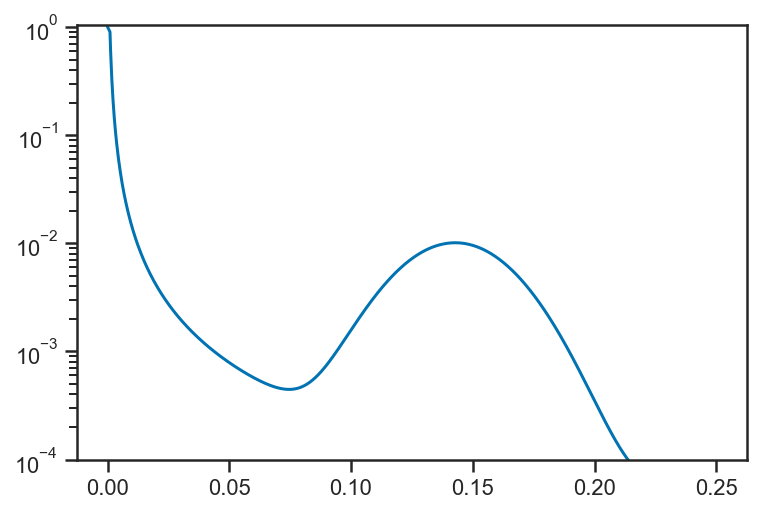

In [7]:
rs = linspace(0, 0.25, 1000)
xi_rs = xi_bao(rs) + xi_pl(rs)
plot(rs, xi_rs)
W_bao = trapz(4*pi*rs*rs*xi_rs, rs)

axis(ymin=1e-4)

yscale('log')

print('Total volume in BAO = {:.5f} Gpc^3 = {:.1f} Mpc^3'.format(W_bao, W_bao*1e9))

Here we compute the power spectrum (FT of the correlation function) on $k = \left(8 h^{-1} \, \mathrm{Mpc}\right)^{-1}$ scales.  The FT of the three-dimensional correlation function reduces to 
$$
P(k) = \int \mathrm{d} r \frac{2 r}{k} \rho(r) \sin\left( 2 \pi k r \right)
$$

In [8]:
rs = linspace(0, 1, 2048)
k8 = 1.0/(8/0.7/1000) # 1/Gpc
P8 = trapz(2*rs*(xi_bao(rs) + xi_pl(rs))*sin(2*pi*k8*rs)/k8, rs)*1e9 # Mpc^3

/Users/wfarr/anaconda3/envs/GWBAO/lib/python3.7/site-packages/ipykernel_launcher.py:14: RuntimeWarning: divide by zero encountered in power
  


In [9]:
print('Power on 8 Mpc scales is {:g} Mpc^3'.format(P8))
sigma_8 = 0.9 # Mpc^3
A2 = sigma_8/P8
print('So fractional amplitude variance parameter is {:g}'.format(A2))

Power on 8 Mpc scales is 27.8115 Mpc^3
So fractional amplitude variance parameter is 0.0323607


Here we reproducably draw from this GP.  We generate a grid in real space, compute the correlation function on the grid, Fourier transform it to get the power spectrum, draw random complex numbers with the appropriate amplitudes, and FT back.

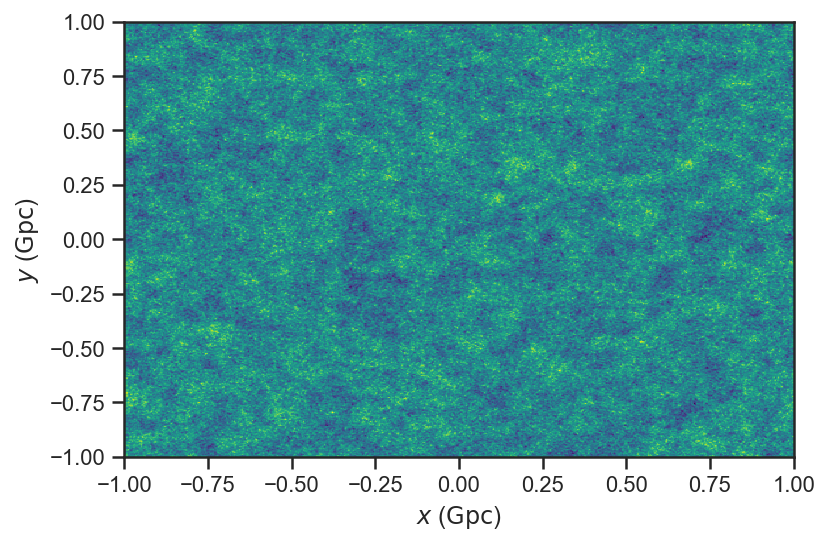

In [14]:
rstate = np.random.get_state()
N = 512
try:
    np.random.seed(1363279349)

    xs = linspace(-1, 1, N)
    
    XS, YS, ZS = meshgrid(xs, xs, xs, indexing='ij')
    
    RS = np.sqrt(XS*XS + YS*YS + ZS*ZS)
    RHOS = A2*(xi_bao(RS) + xi_pl(RS))
    dx = xs[1]-xs[0]
    dk = 1.0/(xs[-1]-xs[0])
    
    P = dx*dx*dx*np.fft.rfftn(RHOS)
    s = sqrt(P)
    ntilde = s*(np.random.randn(*P.shape) + 1j*np.random.randn(*P.shape))
    dn = dk*dk*dk*np.fft.irfftn(ntilde)*N*N*N
    logN = log(n0) + dn
    logNmax = np.max(logN)
    
    pcolormesh(XS[:,:,N//2], YS[:,:,N//2], exp(logN[:,:,N//2]), cmap='viridis')
    xlabel(r'$x$ ($\mathrm{Gpc}$)')
    ylabel(r'$y$ ($\mathrm{Gpc}$)')
    
    pts = []
    with tqdm_notebook(total=5000) as bar:
        while len(pts) < 5000:
            xyz = np.random.uniform(low=-1, high=1, size=3)
            logh = logNmax + log(np.random.random())
            if logh < interpn((xs,xs,xs), logN, xyz) and np.sum(xyz*xyz) < dC_range*dC_range:
                pts.append(xyz)
                bar.update(1)
    pts = np.array(pts)
finally:
    np.random.set_state(rstate)

We make our points into a pandas data frame so that Seaborn is happy plotting it:

In [15]:
pts = pd.DataFrame(data=pts, columns=['x', 'y', 'z'])

Her's what it looks like---pretty uniform, but to my eye there seem to be characteristic scaled gaps that are of order 100 Mpc.

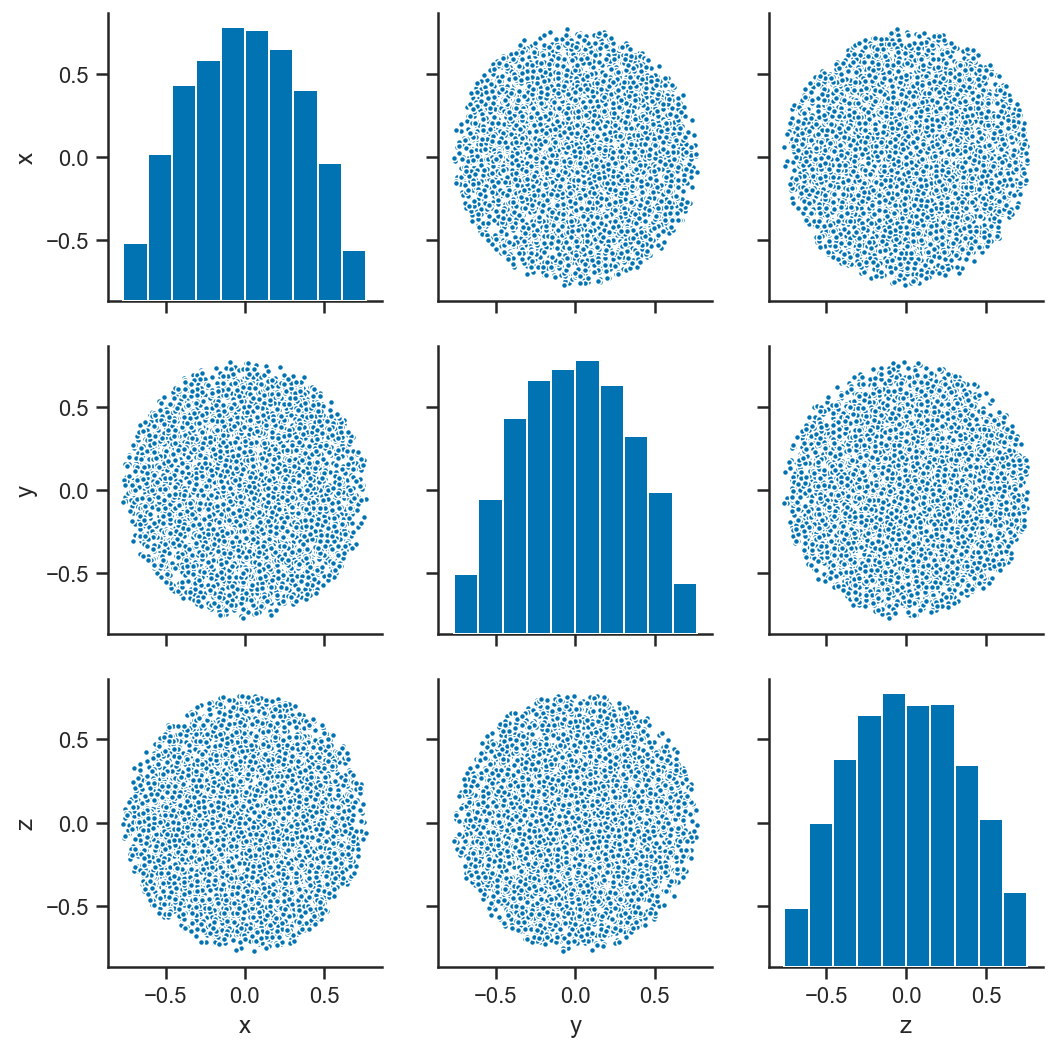

In [16]:
sns.pairplot(pts, markers='.')

In [17]:
with h5py.File('comoving-positions.h5', 'w') as out:
    out.create_dataset('pos', data=pts, compression='gzip', shuffle=True)

In [41]:
def normalize(v):
    return v / np.sqrt(np.sum(v*v))

def draw_observation(xyz):
    x, y, z = xyz
    d = np.sqrt(np.sum(xyz*xyz))
    
    rhat = normalize(xyz)
    
    v = np.random.randn(3)
    vp = v - np.dot(rhat, v)*rhat
    xhat = normalize(vp)
    yhat = np.cross(xhat, rhat)
    
    T_rxy_to_xyz = np.row_stack((rhat, xhat, yhat))
    
    sigma_r = (0.3 + 0.15*np.random.random())*d
    sigma_x = exp(log(6*pi/180) + 0.5*np.random.randn())*d
    sigma_y = exp(log(10*pi/180) + 0.5*np.random.randn())*d
    
    Sigma = np.dot(T_rxy_to_xyz, np.dot(np.diag((sigma_r*sigma_r, sigma_x*sigma_x, sigma_y*sigma_y)), T_rxy_to_xyz.T))
    
    xyz_obs = xyz + np.dot(np.linalg.cholesky(Sigma), randn(3))
    
    return (xyz_obs, Sigma)

In [42]:
rstate = np.random.get_state()
try:
    np.random.seed(32118314)

    pts_obs = pd.DataFrame(columns=['x', 'y', 'z'])
    Sigma_obs = []
    for i, pt in tqdm_notebook(pts.iterrows(), total=pts.shape[0]):
        pt_obs, Sigma = draw_observation(pt)
        pts_obs = pts_obs.append(pt_obs)
        Sigma_obs.append(Sigma)
    Sigma_obs = array(Sigma_obs)
    
finally:
    np.random.set_state(rstate)

In [43]:
with h5py.File('comoving-observations.h5', 'w') as out:
    out.create_dataset('pos', data=pts_obs, compression='gzip', shuffle=True)
    out.create_dataset('Sigma_pos', data=Sigma_obs, compression='gzip', shuffle=True)

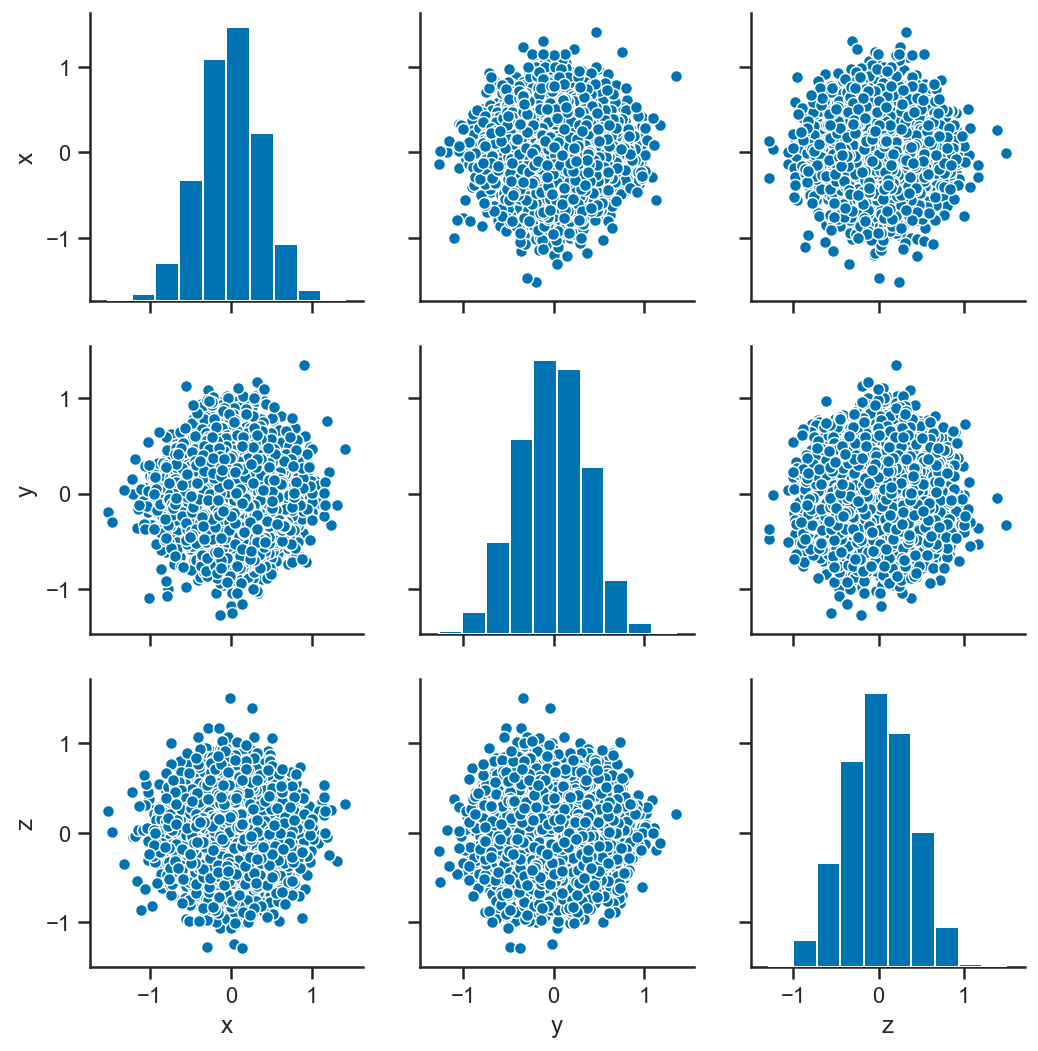

In [44]:
sns.pairplot(pts_obs)